In [1]:
# imports
import sqlalchemy
from sqlalchemy import create_engine, Column, String, Integer, Numeric, MetaData, Table, type_coerce, ForeignKey, case
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
import csv
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
import numbers
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
import glob
import re
from os.path import isfile
import gsw

import createDBfromDFO_OPDB
%matplotlib inline

In [2]:
# definitions
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'DFOOPDB/'
dbname='DFO_OcProfDB'

In [3]:
# if PRISM.sqlite does not exist, run script to create it
if not isfile(basedir + dbname + '.sqlite'):
    import createDBfromDFO_OPDB
    createDBfromDFO_OPDB.main()
    print('done')
else:
    print('file exists')

file exists


In [4]:
Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = True)
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
Station=Base.classes.StationTBL
Obs=Base.classes.ObsTBL
JDFLocs=Base.classes.JDFLocsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)

2016-01-25 15:28:06,602 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1


INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1


2016-01-25 15:28:06,602 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,603 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1


INFO:sqlalchemy.engine.base.Engine:SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1


2016-01-25 15:28:06,603 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,604 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


INFO:sqlalchemy.engine.base.Engine:SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


2016-01-25 15:28:06,605 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,633 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("JDFLocsTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA table_info("JDFLocsTBL")


2016-01-25 15:28:06,633 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,638 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("JDFLocsTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA foreign_key_list("JDFLocsTBL")


2016-01-25 15:28:06,638 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,641 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'JDFLocsTBL' AND type = 'table'


INFO:sqlalchemy.engine.base.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'JDFLocsTBL' AND type = 'table'


2016-01-25 15:28:06,642 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,646 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("StationTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA table_info("StationTBL")


2016-01-25 15:28:06,647 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,652 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("StationTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA foreign_key_list("StationTBL")


2016-01-25 15:28:06,652 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,653 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'StationTBL' AND type = 'table'


INFO:sqlalchemy.engine.base.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'StationTBL' AND type = 'table'


2016-01-25 15:28:06,654 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,663 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("StationTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA index_list("StationTBL")


2016-01-25 15:28:06,664 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,668 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("StationTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA index_list("StationTBL")


2016-01-25 15:28:06,669 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,673 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'StationTBL' AND type = 'table'


INFO:sqlalchemy.engine.base.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'StationTBL' AND type = 'table'


2016-01-25 15:28:06,674 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,681 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("JDFLocsTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA index_list("JDFLocsTBL")


2016-01-25 15:28:06,682 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,688 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("JDFLocsTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA index_list("JDFLocsTBL")


2016-01-25 15:28:06,689 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,692 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'JDFLocsTBL' AND type = 'table'


INFO:sqlalchemy.engine.base.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'JDFLocsTBL' AND type = 'table'


2016-01-25 15:28:06,692 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,697 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("ObsTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA table_info("ObsTBL")


2016-01-25 15:28:06,697 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,914 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("ObsTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA foreign_key_list("ObsTBL")


2016-01-25 15:28:06,915 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,919 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'ObsTBL' AND type = 'table'


INFO:sqlalchemy.engine.base.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'ObsTBL' AND type = 'table'


2016-01-25 15:28:06,919 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,923 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("ObsTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA index_list("ObsTBL")


2016-01-25 15:28:06,923 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,932 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("ObsTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA index_list("ObsTBL")


2016-01-25 15:28:06,932 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:06,943 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'ObsTBL' AND type = 'table'


INFO:sqlalchemy.engine.base.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'ObsTBL' AND type = 'table'


2016-01-25 15:28:06,944 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:07,169 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("StationTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA table_info("StationTBL")


2016-01-25 15:28:07,171 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:07,176 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("StationTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA foreign_key_list("StationTBL")


2016-01-25 15:28:07,176 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:07,177 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'StationTBL' AND type = 'table'


INFO:sqlalchemy.engine.base.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'StationTBL' AND type = 'table'


2016-01-25 15:28:07,177 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:07,181 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("StationTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA index_list("StationTBL")


2016-01-25 15:28:07,181 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:07,184 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("StationTBL")


INFO:sqlalchemy.engine.base.Engine:PRAGMA index_list("StationTBL")


2016-01-25 15:28:07,185 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2016-01-25 15:28:07,187 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'StationTBL' AND type = 'table'


INFO:sqlalchemy.engine.base.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'StationTBL' AND type = 'table'


2016-01-25 15:28:07,188 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


In [5]:
Sal=case([(Obs.Salinity_Bottle!=None, Obs.Salinity_Bottle)], else_=
         case([(Obs.Salinity_T0_C0!=None, Obs.Salinity_T0_C0)], else_=
         case([(Obs.Salinity_T1_C1!=None, Obs.Salinity_T1_C1)], else_=
         case([(Obs.Salinity!=None, Obs.Salinity)], else_=
         case([(Obs.Salinity__Unknown!=None, Obs.Salinity__Unknown)], else_=Obs.Salinity__Pre1978)
        ))))
SalUnits=case([(Obs.Salinity_Bottle!=None, Obs.Salinity_Bottle_units)], else_=
         case([(Obs.Salinity_T0_C0!=None, Obs.Salinity_T0_C0_units)], else_=
         case([(Obs.Salinity_T1_C1!=None, Obs.Salinity_T1_C1_units)], else_=
         case([(Obs.Salinity!=None, Obs.Salinity_units)], else_=
         case([(Obs.Salinity__Unknown!=None, Obs.Salinity__Unknown_units)], else_=Obs.Salinity__Pre1978_units)
        ))))
SalFlag=case([(Obs.Salinity_Bottle!=None, Obs.Flag_Salinity_Bottle)], else_=
         case([(Obs.Salinity_T0_C0!=None, Obs.Flag_Salinity)], else_=
         case([(Obs.Salinity_T1_C1!=None, Obs.Flag_Salinity)], else_=
         case([(Obs.Salinity!=None, Obs.Flag_Salinity)], else_=
         case([(Obs.Salinity__Unknown!=None, Obs.Flag_Salinity)], else_=Obs.Quality_Flag_Sali)
        ))))

In [6]:
NO=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Nitrate_plus_Nitrite)], else_=Obs.Nitrate)
NOUnits=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Nitrate_plus_Nitrite_units)], else_=Obs.Nitrate_units)
NOFlag=case([(Obs.Nitrate_plus_Nitrite!=None, Obs.Flag_Nitrate_plus_Nitrite)], else_=Obs.Flag_Nitrate)
# Obs.Quality_Flag_Nitr does not match any nitrate obs
# ISUS not included in this NO; test separately

In [7]:
Tem=case([(Obs.Temperature!=None, Obs.Temperature)], else_=
         case([(Obs.Temperature_Primary!=None, Obs.Temperature_Primary)], else_=
         case([(Obs.Temperature_Secondary!=None, Obs.Temperature_Secondary)], else_=Obs.Temperature_Reversing)))
TemUnits=case([(Obs.Temperature!=None, Obs.Temperature_units)], else_=
         case([(Obs.Temperature_Primary!=None, Obs.Temperature_Primary_units)], else_=
         case([(Obs.Temperature_Secondary!=None, Obs.Temperature_Secondary_units)], 
              else_=Obs.Temperature_Reversing_units)))
TemFlag=Obs.Quality_Flag_Temp

In [8]:
ratio=Obs.Oxygen_Dissolved_SBE/Obs.Oxygen_Dissolved
qry=session.query(Sal, Obs.Pressure, Station.Lon, Station.Lat, Tem, ratio, Obs.Oxygen_Dissolved, 
                  Obs.Oxygen_Dissolved_SBE).filter(and_(
    Obs.Oxygen_Dissolved_units=='mL/L',
    Obs.Oxygen_Dissolved_SBE_units=='umol/kg',
    Obs.Oxygen_Dissolved!=None,
    Obs.Oxygen_Dissolved_SBE!=None)).limit(50).all()

for row in qry:
    print('%13s %10s %13s %10s %13s %10s %10s %10s' % row)

2016-01-25 15:28:40,551 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.base.Engine:BEGIN (implicit)


2016-01-25 15:28:40,553 INFO sqlalchemy.engine.base.Engine SELECT CASE WHEN ("ObsTBL"."Salinity_Bottle" IS NOT NULL) THEN "ObsTBL"."Salinity_Bottle" ELSE CASE WHEN ("ObsTBL"."Salinity_T0_C0" IS NOT NULL) THEN "ObsTBL"."Salinity_T0_C0" ELSE CASE WHEN ("ObsTBL"."Salinity_T1_C1" IS NOT NULL) THEN "ObsTBL"."Salinity_T1_C1" ELSE CASE WHEN ("ObsTBL"."Salinity" IS NOT NULL) THEN "ObsTBL"."Salinity" ELSE CASE WHEN ("ObsTBL"."Salinity__Unknown" IS NOT NULL) THEN "ObsTBL"."Salinity__Unknown" ELSE "ObsTBL"."Salinity__Pre1978" END END END END END AS anon_1, "ObsTBL"."Pressure" AS "ObsTBL_Pressure", "StationTBL"."Lon" AS "StationTBL_Lon", "StationTBL"."Lat" AS "StationTBL_Lat", CASE WHEN ("ObsTBL"."Temperature" IS NOT NULL) THEN "ObsTBL"."Temperature" ELSE CASE WHEN ("ObsTBL"."Temperature_Primary" IS NOT NULL) THEN "ObsTBL"."Temperature_Primary" ELSE CASE WHEN ("ObsTBL"."Temperature_Secondary" IS NOT NULL) THEN "ObsTBL"."Temperature_Secondary" ELSE "ObsTBL"."Temperature_Reversing" END END END AS an

INFO:sqlalchemy.engine.base.Engine:SELECT CASE WHEN ("ObsTBL"."Salinity_Bottle" IS NOT NULL) THEN "ObsTBL"."Salinity_Bottle" ELSE CASE WHEN ("ObsTBL"."Salinity_T0_C0" IS NOT NULL) THEN "ObsTBL"."Salinity_T0_C0" ELSE CASE WHEN ("ObsTBL"."Salinity_T1_C1" IS NOT NULL) THEN "ObsTBL"."Salinity_T1_C1" ELSE CASE WHEN ("ObsTBL"."Salinity" IS NOT NULL) THEN "ObsTBL"."Salinity" ELSE CASE WHEN ("ObsTBL"."Salinity__Unknown" IS NOT NULL) THEN "ObsTBL"."Salinity__Unknown" ELSE "ObsTBL"."Salinity__Pre1978" END END END END END AS anon_1, "ObsTBL"."Pressure" AS "ObsTBL_Pressure", "StationTBL"."Lon" AS "StationTBL_Lon", "StationTBL"."Lat" AS "StationTBL_Lat", CASE WHEN ("ObsTBL"."Temperature" IS NOT NULL) THEN "ObsTBL"."Temperature" ELSE CASE WHEN ("ObsTBL"."Temperature_Primary" IS NOT NULL) THEN "ObsTBL"."Temperature_Primary" ELSE CASE WHEN ("ObsTBL"."Temperature_Secondary" IS NOT NULL) THEN "ObsTBL"."Temperature_Secondary" ELSE "ObsTBL"."Temperature_Reversing" END END END AS anon_2, "ObsTBL"."Oxygen_D

2016-01-25 15:28:40,553 INFO sqlalchemy.engine.base.Engine ('mL/L', 'umol/kg', 50, 0)


INFO:sqlalchemy.engine.base.Engine:('mL/L', 'umol/kg', 50, 0)


30.6633000000 187.7000000000 -123.9430000000 49.2500000000  7.7257000000       None      0E-10 193.5000000000
31.1890000000 150.9000000000 -123.9430000000 49.2500000000  9.2504000000       None      0E-10 3.0000000000
31.2297000000 175.6000000000 -123.9430000000 49.2500000000  9.2578000000       None      0E-10 3.2000000000
31.2320000000 150.4000000000 -123.9430000000 49.2500000000  9.2676000000       None      0E-10 3.7000000000
31.2330000000 151.6000000000 -123.9430000000 49.2500000000  9.2675000000       None      0E-10 3.4000000000
31.2576000000 175.4000000000 -123.9430000000 49.2500000000  9.2639000000       None      0E-10 3.9000000000
31.2577000000 220.6000000000 -123.9430000000 49.2500000000  9.2689000000       None      0E-10 3.9000000000
31.2705000000 218.4000000000 -123.9430000000 49.2500000000  9.2572000000       None      0E-10 4.9000000000
31.2728000000 216.3000000000 -123.9430000000 49.2500000000  9.2562000000       None      0E-10 4.6000000000
31.2744000000 175.30000000

/home/eolson/anaconda3/envs/teos10/lib/python3.4/site-packages/sqlalchemy/sql/sqltypes.py:562: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


In [9]:
Oxy0=case([(Obs.Oxygen!=None, Obs.Oxygen)], else_=Obs.Oxygen_Dissolved)
Oxy0Units=case([(Obs.Oxygen!=None, Obs.Oxygen_units)], else_=Obs.Oxygen_Dissolved_units)
Oxy0Flag=case([(Obs.Oxygen!=None, Obs.Quality_Flag_Oxyg)], else_=Obs.Flag_Oxygen_Dissolved)

In [10]:
qry=session.query(Oxy0Units, func.count()).filter(Oxy0!=None).group_by(Oxy0Units).all()
for row in qry:
    print(row)

2016-01-25 15:28:46,010 INFO sqlalchemy.engine.base.Engine SELECT CASE WHEN ("ObsTBL"."Oxygen" IS NOT NULL) THEN "ObsTBL"."Oxygen_units" ELSE "ObsTBL"."Oxygen_Dissolved_units" END AS anon_1, count(*) AS count_1 
FROM "ObsTBL" 
WHERE CASE WHEN ("ObsTBL"."Oxygen" IS NOT NULL) THEN "ObsTBL"."Oxygen" ELSE "ObsTBL"."Oxygen_Dissolved" END IS NOT NULL GROUP BY CASE WHEN ("ObsTBL"."Oxygen" IS NOT NULL) THEN "ObsTBL"."Oxygen_units" ELSE "ObsTBL"."Oxygen_Dissolved_units" END


INFO:sqlalchemy.engine.base.Engine:SELECT CASE WHEN ("ObsTBL"."Oxygen" IS NOT NULL) THEN "ObsTBL"."Oxygen_units" ELSE "ObsTBL"."Oxygen_Dissolved_units" END AS anon_1, count(*) AS count_1 
FROM "ObsTBL" 
WHERE CASE WHEN ("ObsTBL"."Oxygen" IS NOT NULL) THEN "ObsTBL"."Oxygen" ELSE "ObsTBL"."Oxygen_Dissolved" END IS NOT NULL GROUP BY CASE WHEN ("ObsTBL"."Oxygen" IS NOT NULL) THEN "ObsTBL"."Oxygen_units" ELSE "ObsTBL"."Oxygen_Dissolved_units" END


2016-01-25 15:28:46,010 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


('mL/L', 36208)
('mg/l', 1859)
('ml/l', 148)
('umol/kg', 13388)


In [11]:
Oxy_mLL=case([(or_(Oxy0Units=='mL/L', Oxy0Units=='ml/l'), Oxy0)], else_=
             case([(Oxy0Units=='mg/l', 22.391/31.998*Oxy0)], else_=None))
Oxy_umolkg=case([(Oxy0Units=='umol/kg', Oxy0)], else_=None)

In [12]:
qry=session.query(Obs.Quality_Flag_Sali, Obs.Salinity, Obs.Salinity_Bottle, Obs.Salinity_T0_C0, 
                  Obs.Salinity_T1_C1, Obs.Salinity__Pre1978, Obs.Salinity__Unknown, Obs.sourceFile
                 ).filter(and_(
            Obs.Quality_Flag_Sali!=None,
            Obs.Salinity__Pre1978==None
            )).all()
for row in qry:
    print('%5s %5s %13s %5s %13s %5s %5s %5s' % row)

2016-01-25 15:28:51,001 INFO sqlalchemy.engine.base.Engine SELECT "ObsTBL"."Quality_Flag_Sali" AS "ObsTBL_Quality_Flag_Sali", "ObsTBL"."Salinity" AS "ObsTBL_Salinity", "ObsTBL"."Salinity_Bottle" AS "ObsTBL_Salinity_Bottle", "ObsTBL"."Salinity_T0_C0" AS "ObsTBL_Salinity_T0_C0", "ObsTBL"."Salinity_T1_C1" AS "ObsTBL_Salinity_T1_C1", "ObsTBL"."Salinity__Pre1978" AS "ObsTBL_Salinity__Pre1978", "ObsTBL"."Salinity__Unknown" AS "ObsTBL_Salinity__Unknown", "ObsTBL"."sourceFile" AS "ObsTBL_sourceFile" 
FROM "ObsTBL" 
WHERE "ObsTBL"."Quality_Flag_Sali" IS NOT NULL AND "ObsTBL"."Salinity__Pre1978" IS NULL


INFO:sqlalchemy.engine.base.Engine:SELECT "ObsTBL"."Quality_Flag_Sali" AS "ObsTBL_Quality_Flag_Sali", "ObsTBL"."Salinity" AS "ObsTBL_Salinity", "ObsTBL"."Salinity_Bottle" AS "ObsTBL_Salinity_Bottle", "ObsTBL"."Salinity_T0_C0" AS "ObsTBL_Salinity_T0_C0", "ObsTBL"."Salinity_T1_C1" AS "ObsTBL_Salinity_T1_C1", "ObsTBL"."Salinity__Pre1978" AS "ObsTBL_Salinity__Pre1978", "ObsTBL"."Salinity__Unknown" AS "ObsTBL_Salinity__Unknown", "ObsTBL"."sourceFile" AS "ObsTBL_sourceFile" 
FROM "ObsTBL" 
WHERE "ObsTBL"."Quality_Flag_Sali" IS NOT NULL AND "ObsTBL"."Salinity__Pre1978" IS NULL


2016-01-25 15:28:51,001 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


   9.  None          None  None          None  None  None UBC EO data request 20160113 c/55010009.UBC
   9.  None          None  None          None  None  None UBC EO data request 20160113 c/55010028.UBC
   9.  None          None  None          None  None  None UBC EO data request 20160113 c/55010033.UBC
   9.  None          None  None          None  None  None UBC EO data request 20160113 c/55010033.UBC
   9.  None          None  None          None  None  None UBC EO data request 20160113 c/55010033.UBC
   9.  None          None  None          None  None  None UBC EO data request 20160113 c/55010033.UBC
   9.  None          None  None          None  None  None UBC EO data request 20160113 c/55010049.UBC
   9.  None          None  None          None  None  None UBC EO data request 20160113 c/55010060.UBC
   9.  None          None  None          None  None  None UBC EO data request 20160113 c/55010060.UBC


/home/eolson/anaconda3/envs/teos10/lib/python3.4/site-packages/sqlalchemy/sql/sqltypes.py:562: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


In [13]:
qJDFLoc=session.query(Obs.ID, Station.ID).filter(
    and_(
        Station.Lat > 48.2,
        Station.Lat < 48.8,
        Station.Lon > -125.2,
        Station.Lon < -124.2
        )).join(Station, Obs.StationTBLID==Station.ID)
print(qJDFLoc.count())

2016-01-25 15:28:53,383 INFO sqlalchemy.engine.base.Engine SELECT count(*) AS count_1 
FROM (SELECT "ObsTBL"."ID" AS "ObsTBL_ID", "StationTBL"."ID" AS "StationTBL_ID" 
FROM "ObsTBL" JOIN "StationTBL" ON "ObsTBL"."StationTBLID" = "StationTBL"."ID" 
WHERE "StationTBL"."Lat" > ? AND "StationTBL"."Lat" < ? AND "StationTBL"."Lon" > ? AND "StationTBL"."Lon" < ?) AS anon_1


INFO:sqlalchemy.engine.base.Engine:SELECT count(*) AS count_1 
FROM (SELECT "ObsTBL"."ID" AS "ObsTBL_ID", "StationTBL"."ID" AS "StationTBL_ID" 
FROM "ObsTBL" JOIN "StationTBL" ON "ObsTBL"."StationTBLID" = "StationTBL"."ID" 
WHERE "StationTBL"."Lat" > ? AND "StationTBL"."Lat" < ? AND "StationTBL"."Lon" > ? AND "StationTBL"."Lon" < ?) AS anon_1


2016-01-25 15:28:53,384 INFO sqlalchemy.engine.base.Engine (48.2, 48.8, -125.2, -124.2)


INFO:sqlalchemy.engine.base.Engine:(48.2, 48.8, -125.2, -124.2)


2771


In [14]:
test=session.query(JDFLocs).count()
print(test)

2016-01-25 15:29:01,827 INFO sqlalchemy.engine.base.Engine SELECT count(*) AS count_1 
FROM (SELECT "JDFLocsTBL"."ObsID" AS "JDFLocsTBL_ObsID", "JDFLocsTBL"."StationID" AS "JDFLocsTBL_StationID" 
FROM "JDFLocsTBL") AS anon_1


INFO:sqlalchemy.engine.base.Engine:SELECT count(*) AS count_1 
FROM (SELECT "JDFLocsTBL"."ObsID" AS "JDFLocsTBL_ObsID", "JDFLocsTBL"."StationID" AS "JDFLocsTBL_StationID" 
FROM "JDFLocsTBL") AS anon_1


2016-01-25 15:29:01,828 INFO sqlalchemy.engine.base.Engine ()


INFO:sqlalchemy.engine.base.Engine:()


2771


In [18]:
qdata=session.query(JDFLocs.ObsID, Station.Lat, Station.Lon, Obs.Depth, Obs.Pressure, Tem, Sal, NO, 
            Oxy_mLL).join(Obs, JDFLocs.ObsID==Obs.ID).join(Station, Obs.StationTBLID==Station.ID).filter(and_(
                        Obs.Depth>50,
                        Tem!=None, 
                        Sal!=None,
                        NO!=None,
                        Oxy_mLL!=None)
                        )
print(qdata.count())

2016-01-25 15:31:16,516 INFO sqlalchemy.engine.base.Engine SELECT count(*) AS count_1 
FROM (SELECT "JDFLocsTBL"."ObsID" AS "JDFLocsTBL_ObsID", "StationTBL"."Lat" AS "StationTBL_Lat", "StationTBL"."Lon" AS "StationTBL_Lon", "ObsTBL"."Depth" AS "ObsTBL_Depth", "ObsTBL"."Pressure" AS "ObsTBL_Pressure", CASE WHEN ("ObsTBL"."Temperature" IS NOT NULL) THEN "ObsTBL"."Temperature" ELSE CASE WHEN ("ObsTBL"."Temperature_Primary" IS NOT NULL) THEN "ObsTBL"."Temperature_Primary" ELSE CASE WHEN ("ObsTBL"."Temperature_Secondary" IS NOT NULL) THEN "ObsTBL"."Temperature_Secondary" ELSE "ObsTBL"."Temperature_Reversing" END END END AS anon_2, CASE WHEN ("ObsTBL"."Salinity_Bottle" IS NOT NULL) THEN "ObsTBL"."Salinity_Bottle" ELSE CASE WHEN ("ObsTBL"."Salinity_T0_C0" IS NOT NULL) THEN "ObsTBL"."Salinity_T0_C0" ELSE CASE WHEN ("ObsTBL"."Salinity_T1_C1" IS NOT NULL) THEN "ObsTBL"."Salinity_T1_C1" ELSE CASE WHEN ("ObsTBL"."Salinity" IS NOT NULL) THEN "ObsTBL"."Salinity" ELSE CASE WHEN ("ObsTBL"."Salinity__U

INFO:sqlalchemy.engine.base.Engine:SELECT count(*) AS count_1 
FROM (SELECT "JDFLocsTBL"."ObsID" AS "JDFLocsTBL_ObsID", "StationTBL"."Lat" AS "StationTBL_Lat", "StationTBL"."Lon" AS "StationTBL_Lon", "ObsTBL"."Depth" AS "ObsTBL_Depth", "ObsTBL"."Pressure" AS "ObsTBL_Pressure", CASE WHEN ("ObsTBL"."Temperature" IS NOT NULL) THEN "ObsTBL"."Temperature" ELSE CASE WHEN ("ObsTBL"."Temperature_Primary" IS NOT NULL) THEN "ObsTBL"."Temperature_Primary" ELSE CASE WHEN ("ObsTBL"."Temperature_Secondary" IS NOT NULL) THEN "ObsTBL"."Temperature_Secondary" ELSE "ObsTBL"."Temperature_Reversing" END END END AS anon_2, CASE WHEN ("ObsTBL"."Salinity_Bottle" IS NOT NULL) THEN "ObsTBL"."Salinity_Bottle" ELSE CASE WHEN ("ObsTBL"."Salinity_T0_C0" IS NOT NULL) THEN "ObsTBL"."Salinity_T0_C0" ELSE CASE WHEN ("ObsTBL"."Salinity_T1_C1" IS NOT NULL) THEN "ObsTBL"."Salinity_T1_C1" ELSE CASE WHEN ("ObsTBL"."Salinity" IS NOT NULL) THEN "ObsTBL"."Salinity" ELSE CASE WHEN ("ObsTBL"."Salinity__Unknown" IS NOT NULL) THE

2016-01-25 15:31:16,517 INFO sqlalchemy.engine.base.Engine ('mL/L', 'ml/l', 'mg/l', 0.6997624851553221, 50, 'mL/L', 'ml/l', 'mg/l', 0.6997624851553221)


INFO:sqlalchemy.engine.base.Engine:('mL/L', 'ml/l', 'mg/l', 0.6997624851553221, 50, 'mL/L', 'ml/l', 'mg/l', 0.6997624851553221)


112


In [43]:
Lat=[]
Lon=[]
z=[]
P=[]
T=[]
S=[]
N=[]
O=[]
for row in qdata.all():
    Lat.append(row[1])
    Lon.append(row[2])
    z.append(row[3])
    P.append(row[4])
    T.append(float(row[5]))
    S.append(float(row[6]))
    N.append(float(row[7]))
    O.append(float(row[8]))

2016-01-25 15:42:52,805 INFO sqlalchemy.engine.base.Engine SELECT "JDFLocsTBL"."ObsID" AS "JDFLocsTBL_ObsID", "StationTBL"."Lat" AS "StationTBL_Lat", "StationTBL"."Lon" AS "StationTBL_Lon", "ObsTBL"."Depth" AS "ObsTBL_Depth", "ObsTBL"."Pressure" AS "ObsTBL_Pressure", CASE WHEN ("ObsTBL"."Temperature" IS NOT NULL) THEN "ObsTBL"."Temperature" ELSE CASE WHEN ("ObsTBL"."Temperature_Primary" IS NOT NULL) THEN "ObsTBL"."Temperature_Primary" ELSE CASE WHEN ("ObsTBL"."Temperature_Secondary" IS NOT NULL) THEN "ObsTBL"."Temperature_Secondary" ELSE "ObsTBL"."Temperature_Reversing" END END END AS anon_1, CASE WHEN ("ObsTBL"."Salinity_Bottle" IS NOT NULL) THEN "ObsTBL"."Salinity_Bottle" ELSE CASE WHEN ("ObsTBL"."Salinity_T0_C0" IS NOT NULL) THEN "ObsTBL"."Salinity_T0_C0" ELSE CASE WHEN ("ObsTBL"."Salinity_T1_C1" IS NOT NULL) THEN "ObsTBL"."Salinity_T1_C1" ELSE CASE WHEN ("ObsTBL"."Salinity" IS NOT NULL) THEN "ObsTBL"."Salinity" ELSE CASE WHEN ("ObsTBL"."Salinity__Unknown" IS NOT NULL) THEN "ObsTBL"

INFO:sqlalchemy.engine.base.Engine:SELECT "JDFLocsTBL"."ObsID" AS "JDFLocsTBL_ObsID", "StationTBL"."Lat" AS "StationTBL_Lat", "StationTBL"."Lon" AS "StationTBL_Lon", "ObsTBL"."Depth" AS "ObsTBL_Depth", "ObsTBL"."Pressure" AS "ObsTBL_Pressure", CASE WHEN ("ObsTBL"."Temperature" IS NOT NULL) THEN "ObsTBL"."Temperature" ELSE CASE WHEN ("ObsTBL"."Temperature_Primary" IS NOT NULL) THEN "ObsTBL"."Temperature_Primary" ELSE CASE WHEN ("ObsTBL"."Temperature_Secondary" IS NOT NULL) THEN "ObsTBL"."Temperature_Secondary" ELSE "ObsTBL"."Temperature_Reversing" END END END AS anon_1, CASE WHEN ("ObsTBL"."Salinity_Bottle" IS NOT NULL) THEN "ObsTBL"."Salinity_Bottle" ELSE CASE WHEN ("ObsTBL"."Salinity_T0_C0" IS NOT NULL) THEN "ObsTBL"."Salinity_T0_C0" ELSE CASE WHEN ("ObsTBL"."Salinity_T1_C1" IS NOT NULL) THEN "ObsTBL"."Salinity_T1_C1" ELSE CASE WHEN ("ObsTBL"."Salinity" IS NOT NULL) THEN "ObsTBL"."Salinity" ELSE CASE WHEN ("ObsTBL"."Salinity__Unknown" IS NOT NULL) THEN "ObsTBL"."Salinity__Unknown" ELS

2016-01-25 15:42:52,806 INFO sqlalchemy.engine.base.Engine ('mL/L', 'ml/l', 'mg/l', 0.6997624851553221, 50, 'mL/L', 'ml/l', 'mg/l', 0.6997624851553221)


INFO:sqlalchemy.engine.base.Engine:('mL/L', 'ml/l', 'mg/l', 0.6997624851553221, 50, 'mL/L', 'ml/l', 'mg/l', 0.6997624851553221)


In [44]:
print(T[0])

8.58


In [45]:
N=np.array(N)
S=np.array(S)
T=np.array(T)
O=np.array(O)

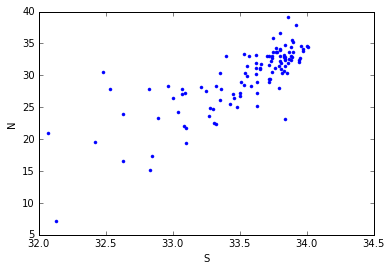

In [46]:
plt.plot(S,N,'.')
plt.xlabel('S')
plt.ylabel('N')

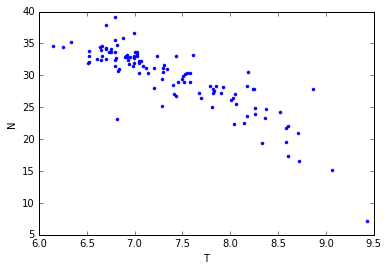

In [47]:
plt.plot(T,N,'.')
plt.xlabel('T')
plt.ylabel('N')

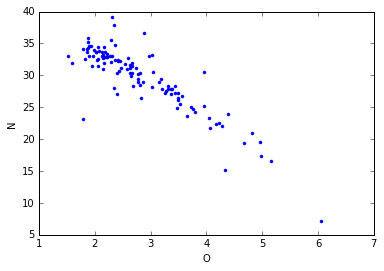

In [48]:
plt.plot(O,N,'.')
plt.xlabel('O')
plt.ylabel('N')

In [49]:
a=np.vstack([T,S,O,np.ones(len(T))]).T
m = np.linalg.lstsq(a,N)[0]
mT, mS, mO, mC = m
print(mT, mS, mO, mC)

-2.95719502188 -0.795545976565 -3.24896843409 87.3229702373


AttributeError: Neither 'BinaryExpression' object nor 'Comparator' object has an attribute 'T'

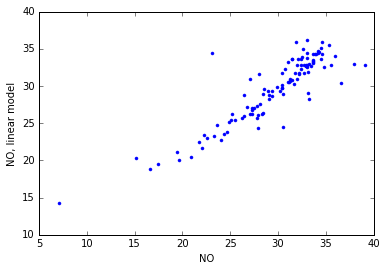

In [50]:
plt.plot(N,np.dot(a,m),'.')
plt.xlabel('NO')
plt.ylabel('NO, linear model')
SSE=np.dot((NO-np.dot(a,m)),(NO-np.dot(a,m)).T)
plt.title('Linear Model: NO(T,S)')
print('SSE=', SSE)
plt.plot(np.array([0,40]), np.array([0, 40]),'r-')

In [ ]:
session.close()
engine.dispose()